In [18]:
import pandas as pd
import numpy as np
from basic_ollama_agent import OllamaAgent
import ollama
import json
import inspect
from typing import List, Callable, Optional, Any, Dict
from pydantic import BaseModel
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_excel("bank_earnings_data_2019-01-01_2025-12-31.xlsx", sheet_name="Bank_Earnings_Data")
df.head()

,Datetime,CompanyName,TotalRevenue,InterestIncome,NonInterestIncome,InterestExpense,NetInterestIncome,ProvisionForLoanLosses,NonInterestExpense,NetIncome,EarningsPerShare,TotalAssets,TotalLoans,TotalDeposits,ShareholdersEquity
0,2019-03-31,AMERICAN EXPRESS COMPANY,6.697000e+09,2.725000e+09,8.305000e+09,8.950000e+08,2.059000e+09,5.250000e+08,7.597000e+09,1.550000e+09,1.81,1.971930e+11,NaN,7.285700e+10,22218000000
1,2019-06-30,AMERICAN EXPRESS COMPANY,1.377600e+10,5.489000e+09,1.706900e+10,1.786000e+09,4.133000e+09,1.128000e+09,1.535500e+10,3.311000e+09,3.88,1.976030e+11,NaN,7.259000e+10,23092000000
2,2019-09-30,AMERICAN EXPRESS COMPANY,2.082700e+10,8.374000e+09,2.585500e+10,2.663000e+09,6.336000e+09,1.732000e+09,2.319900e+10,5.066000e+09,5.97,1.941840e+11,NaN,7.329800e+10,23025000000
3,2019-12-31,AMERICAN EXPRESS COMPANY,2.815900e+10,1.130800e+10,3.493600e+10,3.464000e+09,8.620000e+09,2.462000e+09,3.155400e+10,6.759000e+09,8.00,1.983210e+11,NaN,7.328700e+10,23071000000
4,2020-03-31,AMERICAN EXPRESS COMPANY,6.296000e+09,2.909000e+09,7.980000e+09,7.160000e+08,2.330000e+09,1.876000e+09,7.237000e+09,3.670000e+08,0.41,1.860600e+11,NaN,7.796200e+10,21006000000


In [23]:
### Generate prompt
role = "You are an expert Earnings Data Extractor and Analyzer. " 
task = "Call the appropriate functions to extract the earnings data from the DataFrame and analyze it for the companies mentioned.\n"

context_company_names = "\nWhen the user asks to search for a company, try to map their mentioned name to a list of pre-defined companies. The allowed company names are as follows enclosed in <company> tag: <company> "+ f"{', '.join(df['CompanyName'].unique().tolist())}" + "</company>\n"

Context = "\nHere are the metrics present in the data, enclosed in <column> tags: \n<columns>" + f"{', '.join(df.columns.tolist()[2:])}" + "</columns>"
prompt = role + task + context_company_names + Context

print(prompt)


You are an expert Earnings Data Extractor and Analyzer. Call the appropriate functions to extract the earnings data from the DataFrame and analyze it for the companies mentioned.

When the user asks to search for a company, try to map their mentioned name to a list of pre-defined companies. The allowed company names are as follows enclosed in <company> tag: <company> AMERICAN EXPRESS COMPANY, Bank of America Corporation, CAPITAL ONE FINANCIAL CORP, Citigroup Inc, Fifth Third Bancorp, Huntington Bancshares Incorporated, JPMorgan Chase & Co, KeyCorp, NORTHERN TRUST CORPORATION, PNC Financial Services Group, Inc., People's United Financial, Inc., SCHWAB CHARLES CORP, STATE STREET CORPORATION, TEGNA INC., THE BANK OF NEW YORK MELLON CORPORATION, TRUIST FINANCIAL CORPORATION, The Goldman Sachs Group, Inc., US BANCORP \DE\, WELLS FARGO & COMPANY/MN</company>

Here are the metrics present in the data, enclosed in <column> tags: 
<columns>TotalRevenue, InterestIncome, NonInterestIncome, Intere

## Basic Agent

In [24]:
# Example tool functions
def get_product(a: int, b: int) -> int:
    """
    Computes the product of two numbers.
    """
    return int(a) * int(b)

def calculate_sum(a: int, b: int) -> int:
    """
    Calculate the sum of two numbers.
    
    Args:
        a: First number
        b: Second number
    """
    return a + b

# Example output schema
class WeatherResponse(BaseModel):
    location: str
    temperature: float
    units: str
    description: str

# Create agent
agent = OllamaAgent(
    model_name="llama3.2:1b",
    tools=[get_product, calculate_sum],
    output_schema=None
)

# Use agent
result = agent.invoke("What's the Sum of 11 and 22? Also, what's the product of 11 and 22?")
print(result)

{'message': '', 'tool_calls': [{'tool': 'calculate_sum', 'arguments': {'a': '11', 'b': '22'}, 'result': '1122'}, {'tool': 'get_product', 'arguments': {'a': '11', 'b': '22'}, 'result': 242}], 'structured_output': None}


Timestamp('2025-03-31 00:00:00')

In [36]:
def compare_metrics_latest(company_names: str, metric: str):
    """
    This function compares the latest values of a specified metric for a list of companies.

    Args:
        company_names (str): Comma-separated string of company names to compare.
        metric (str): The metric to compare, e.g., 'EPS', 'Revenue', etc.

    Returns:
        pd.DataFrame: A DataFrame containing the latest values of the specified metric for the given companies.
    
    Raises:
        ValueError: If the metric is not found in the DataFrame.
    """
    company_names = [name.strip() for name in company_names.split(',')]
    latest_date = df['Datetime'].max()
    
    # Filter df
    latest_data = df[df['Datetime'] == latest_date]

    # Select relevant companies
    latest_data = latest_data[latest_data['CompanyName'].isin(company_names)]

    # Check if metric exists
    if metric not in latest_data.columns:
        raise ValueError(f"Metric '{metric}' not found in the data.")
    
    # Extract the relevant data
    metric_data = latest_data[['CompanyName', metric]].set_index('CompanyName')

    return metric_data



def plot_metrics_comparison_latest(company_names: str, metric: str):
    """
    This function plots the latest values of a specified metric for a list of companies.

    Args:
        company_names (str): Comma-separated string of company names to compare.
        metric (str): The metric to compare, e.g., 'EPS', 'Revenue', etc.

    Returns:
        Matplotlib plot: A plot containing the latest values of the specified metric for the given companies.

    Raises:
        ValueError: If the metric is not found in the DataFrame.
    """
    company_names = [name.strip() for name in company_names.split(',')]
    print(company_names)
    latest_date = df['Datetime'].max()
    
    # Filter df
    latest_data = df[df['Datetime'] == latest_date]

    # Select relevant companies
    latest_data = latest_data[latest_data['CompanyName'].isin(company_names)]

    # Check if metric exists
    if metric not in latest_data.columns:
        raise ValueError(f"Metric '{metric}' not found in the data.")
    
    # Extract the relevant data
    metric_data = latest_data[['CompanyName', metric]].set_index('CompanyName')
    metric_data = metric_data.sort_values(by=metric, ascending=False)
    
    # Plotting  
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric_data.index, y=metric_data[metric], palette='viridis')
    plt.title(f'Latest {metric} Comparison for Companies')
    plt.xlabel('Company Name')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return plt

['WELLS FARGO & COMPANY/MN', 'JPMORGAN CHASE & CO', 'CITIGROUP INC', 'AMERICAN EXPRESS COMPANY', 'BANK OF AMERICA CORPORATION']


/tmp/ipykernel_21695/1708979261.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_data.index, y=metric_data[metric], palette='viridis')


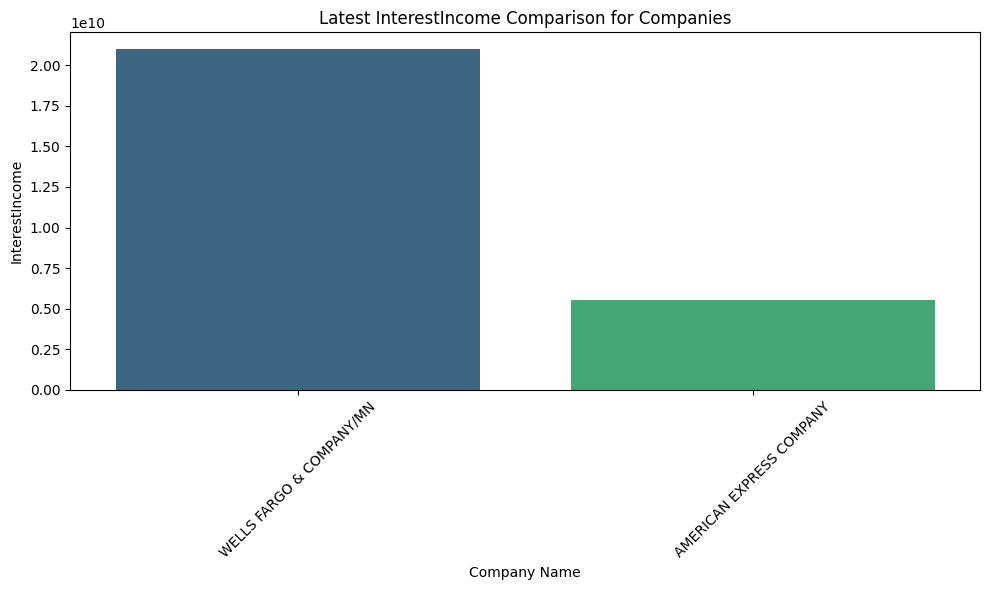

{'message': '', 'tool_calls': [{'tool': 'plot_metrics_comparison_latest', 'arguments': {'company_names': 'WELLS FARGO & COMPANY/MN, JPMORGAN CHASE & CO, CITIGROUP INC, AMERICAN EXPRESS COMPANY, BANK OF AMERICA CORPORATION', 'metric': 'InterestIncome'}, 'result': <module 'matplotlib.pyplot' from '/home/nitish/Documents/github/PublicReportResearch/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>}], 'structured_output': None}


In [37]:
# Create agent
agent = OllamaAgent(
    model_name="qwen2.5:7b",
    tools=[compare_metrics_latest, plot_metrics_comparison_latest],
    output_schema=None
)

# Use agent
result = agent.invoke(prompt + "Plot the interest income of wells fargo, JP morgan, citi, american express and bank of america for the latest date.")
print(result)